# Cleaning and Analysing Eviction Data
Source: https://data.london.gov.uk/dataset/mortgage-and-landlord-possession-actions-borough

### <u>Importing Packages and Functions<u>

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import math

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
mms  = MinMaxScaler(feature_range=(0,1))
stds = StandardScaler()
rbs  = RobustScaler()
pts  = PowerTransformer()

In [3]:
# These are specific to NLP
import nltk
import spacy
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()
mms  = MinMaxScaler(feature_range=(-1,1))
stds = StandardScaler()
rbs  = RobustScaler()
pts  = PowerTransformer()

import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

In [4]:
# This is the Cache Function Jon wrote
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

### <u>Cleaning the Data<u>

In [5]:
evictions2019 = pd.read_excel('2019mortgage-landlord-possession-actions.xls', skiprows=[0,1,2], sheet_name = 'Table',header=[1])
evictions2022 = pd.read_excel('2022mortgage-landlord-possession-actions.xls', skiprows=[0,1,2], sheet_name = 'Table',header=[1])

In [6]:
evictions2019.head(10)

,Area,Claims,Warrants,Repossessions,Outright Orders,Suspended Orders
0,Barking and Dagenham,129,100,12,48.00,34.00
1,Barnet,180,118,10,81.00,25.00
2,Bexley,146,101,20,52.00,61.00
3,Brent,128,97,8,52.00,39.00
4,Bromley,151,81,13,42.00,36.00
5,Camden,62,31,6,23.00,5.00
6,City of London,3,2,2,NaN,NaN
7,Croydon,293,226,48,108.00,53.00
8,Ealing,145,92,17,53.00,32.00
9,Enfield,194,118,22,65.00,39.00


In [7]:
evictions2019.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Area              33 non-null     object 
 1   Claims            33 non-null     int64  
 2   Warrants          33 non-null     int64  
 3   Repossessions     33 non-null     int64  
 4   Outright Orders   32 non-null     float64
 5   Suspended Orders  32 non-null     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 1.7+ KB


In [8]:
evictions2019['sum'] = evictions2019.iloc[:, 1:6].apply(lambda row: row.sum().astype(int), axis=1)
evictions2022['sum'] = evictions2022.iloc[:, 1:6].apply(lambda row: row.sum().astype(int), axis=1)

In [9]:
evictions2019.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Area              33 non-null     object 
 1   Claims            33 non-null     int64  
 2   Warrants          33 non-null     int64  
 3   Repossessions     33 non-null     int64  
 4   Outright Orders   32 non-null     float64
 5   Suspended Orders  32 non-null     float64
 6   sum               33 non-null     int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 1.9+ KB


### <u>Mapping<u>

In [10]:
# some shapefiles
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path
ddir  = os.path.join('data','geo') # destination directory
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

Found data/geo/Water.gpkg locally!
Found data/geo/Boroughs.gpkg locally!
Found data/geo/Greenspace.gpkg locally!


In [11]:
boros.head(5)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry
0,Kingston upon Thames,E09000021,"3,726.12",0.00,F,"MULTIPOLYGON (((516401.600 160201.800, 516407...."
1,Croydon,E09000008,"8,649.44",0.00,F,"MULTIPOLYGON (((535009.200 159504.700, 535005...."
2,Bromley,E09000006,"15,013.49",0.00,F,"MULTIPOLYGON (((540373.600 157530.400, 540361...."
3,Hounslow,E09000018,"5,658.54",60.76,F,"MULTIPOLYGON (((521975.800 178100.000, 521967...."
4,Ealing,E09000009,"5,554.43",0.00,F,"MULTIPOLYGON (((510253.500 182881.600, 510249...."


In [16]:
evict2019_geom = pd.merge(evictions2019, boros, how="left", left_on='Area', right_on='NAME')
evict2022_geom = pd.merge(evictions2022, boros, how="left", left_on='Area', right_on='NAME')

<AxesSubplot:ylabel='Frequency'>

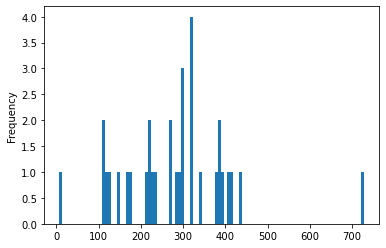

In [13]:
evict_sums2019 = evict2019_geom['sum']
evict_sums2019.plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

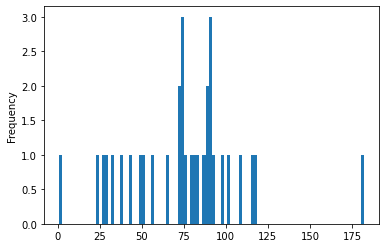

In [14]:
evict_sums2022 = evict2022_geom['sum']
evict_sums2022.plot.hist(bins=100)

In [15]:
evict2019_geom['area'] = evict2019_geom.area

AttributeError: 'DataFrame' object has no attribute 'area'

In [ ]:
evict2022_geom['area'] = evict2022_geom.area

In [ ]:
evict2019_geom['density'] =  (evict2019_geom['sum'] / evict2019_geom['area'])*1e6
#1e6 converts to km sq not m sq

In [ ]:
evict2022_geom['density'] =  (evict2022_geom['sum'] / evict2022_geom['area'])*1e6
#1e6 converts to km sq not m sq

In [ ]:
from sklearn.preprocessing import power_transform
evict2019_geom["transformed_evict"] = power_transform(evict2019_geom[["density"]], method='yeo-johnson')

In [ ]:
from sklearn.preprocessing import power_transform
evict2022_geom["transformed_evict"] = power_transform(evict2022_geom[["density"]], method='yeo-johnson')

In [ ]:
# Transform the "sum_evictions" column
mms.fit(evict2019_geom[["sum"]])
evict2019_geom["transformed_mms"] = mms.transform(evict2019_geom[["density"]])

In [ ]:
# Transform the "sum_evictions" column
mms.fit(evict2022_geom[["sum"]])
evict2022_geom["transformed_mms"] = mms.transform(evict2022_geom[["density"]])

In [ ]:
#HERE I NEED TO MAP THE COUNT OF EVICTIONS THAT HAVE BEEN STANDARDISED
evict2019_geom = evict2019_geom.set_geometry('geometry')
evict2019_geom.plot(column='transformed_mms', legend=True, figsize=(8,8));
plt.suptitle("Density of Evictions based on Min-Max Scaler", fontsize=14, fontweight='bold');

In [ ]:
#HERE I NEED TO MAP THE COUNT OF EVICTIONS THAT HAVE BEEN STANDARDISED
evict2022_geom = evict2022_geom.set_geometry('geometry')
evict2022_geom.plot(column='transformed_mms', legend=True, figsize=(8,8));
plt.suptitle("Density of Evictions based on Min-Max Scaler", fontsize=14, fontweight='bold');